In [54]:
import os
import torch
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_filtering as depth_filtering
import custom_utils.depth_anything_interface as get_model
import numpy as np
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression

DATAFILE = "/scratchdata/far"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = get_model.get_model(DEVICE)

/depth-stereo/scripts/custom_utils/depth_anything_interface.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/scratchdata/depth_anythi

In [55]:
# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

In [56]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/depth/points"]):
    wait += 1
    if wait == 6:
        print(len(msg.data))
        pc_raw = np.frombuffer(msg.data, dtype=np.uint8)
        print(pc_raw)
        print(msg.fields)
        

3783104
[205  59 172 ...  64 254 191]
[name: "x"
offset: 0
datatype: 7
count: 1, name: "y"
offset: 4
datatype: 7
count: 1, name: "z"
offset: 8
datatype: 7
count: 1]


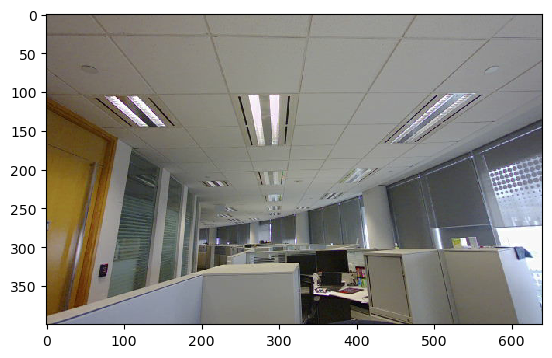

In [57]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    wait += 1
    if wait == 10:
        img = data_conversion.topic_to_image(msg)
        break

plt.imshow(img)
plt.imsave(os.path.join(DATAFILE, "color.png"), img)

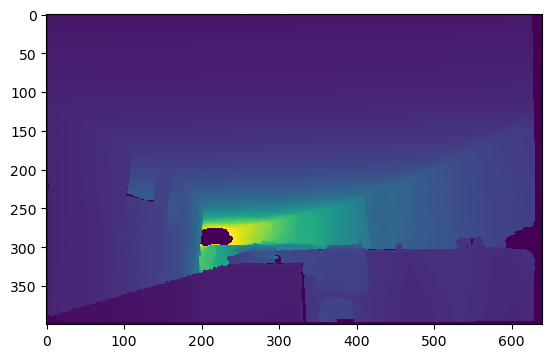

In [58]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    wait += 1
    if wait == 10:
        depth = data_conversion.topic_to_depth(msg)
        break

plt.imshow(depth)

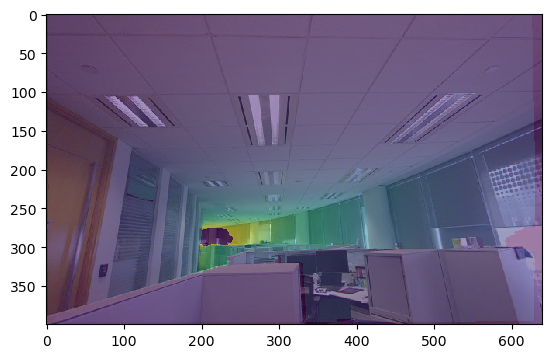

In [59]:
# Overlay image overdepth at half alpha
plt.imshow(depth)
plt.imshow(img, alpha=0.5)

/tmp/ipykernel_22978/2430795002.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(1/est_depth)


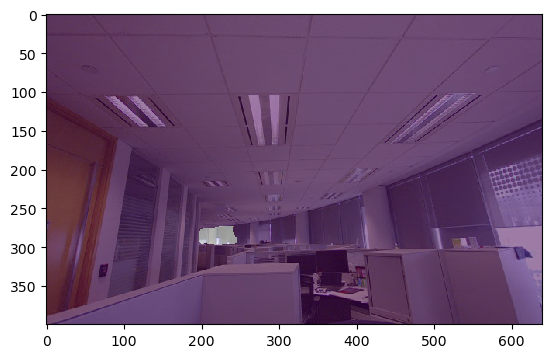

In [60]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

plt.imshow(1/est_depth)
plt.imshow(img, alpha=0.5)

R2: 0.9738374640103096


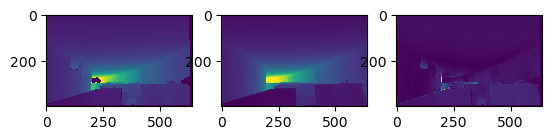

In [107]:
depth_flatten = depth.flatten()
est_depth_flatten = 1/(est_depth.flatten()+25)
est_depth_flatten = est_depth_flatten[depth_flatten!=0]
depth_flatten = depth_flatten[depth_flatten!=0]
#depth_flatten = depth_flatten[est_depth_flatten < 1]
#est_depth_flatten = est_depth_flatten[est_depth_flatten < 1]

# Calculate best fit in numpy
p = np.polyfit(est_depth_flatten, depth_flatten, 1)

pred = np.polyval(p, 1/(est_depth.flatten()+25)).reshape(depth.shape)

# Calcualte r2
r2 = np.corrcoef(est_depth_flatten, depth_flatten)[0, 1]
print(f"R2: {r2}")

fig, axs = plt.subplots(1, 3)

depth_normalised = depth_filtering.normalise(depth)
pred_normalised = depth_filtering.normalise(pred)

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
diff[depth==0] = 0
axs[2].imshow(diff)

#plt.scatter(est_depth_flatten, depth_flatten)

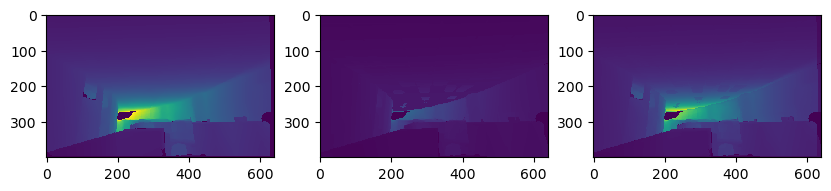

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


axs[0].imshow(depth_filtering.normalise(depth))
axs[1].imshow(depth_filtering.normalise(-est_depth))
axs[1].imshow(depth_filtering.normalise(all_corrected_depth))
axs[2].imshow(abs(depth_filtering.normalise(depth) - depth_filtering.normalise(all_corrected_depth)))

plt.show()